## Ring-hydroxylating Dioxygenases

In [148]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from prince import CA, MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
import networkx as nx
from itertools import combinations
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import to_tree
from operator import itemgetter
import fastcluster
import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import fcluster


# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Utils

def henikoff(data):
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    size, length = data_array.shape
    weights = []
    for seq_index in range(size):
        row = data_array[seq_index, :]
        unique_vals, counts = np.unique(row, return_counts=True)
        k = len(unique_vals)
        matrix_row = 1. / (k * counts)
        weights.append(np.sum(matrix_row) / length)
    return pd.Series(weights, index=data.index)

def get_newick(node, parent_dist, leaf_names, newick=""):
    if node.is_leaf():
        return f"{leaf_names[node.id]}:{parent_dist - node.dist:.2f}{newick}"
    else:
        if len(newick) > 0:
            newick = f"):{parent_dist - node.dist:.2f}{newick}"
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, f",{newick}")
        newick = f"({newick}"
        return newick

In [2]:
headers, sequences = [], []
for record in SeqIO.parse('alignment.fasta', "fasta").records:
    headers.append(record.id)
    sequences.append(record.seq)
raw = np.array(sequences)
print(raw.shape)

(9381, 1225)


In [127]:
# Create a data frame from array containing raw data and then clean it up

df = pd.DataFrame(raw)

df.replace(
    ['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]],
    np.nan,
    inplace=True
)

threshold = .9
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df.dropna(thresh=min_rows, axis=1, inplace=True)
min_cols = int(threshold * df.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df.dropna(thresh=min_cols, axis=0, inplace=True)

row_idx, col_idx = df.index, df.columns

print(df.info)

7035 120
<bound method DataFrame.info of      146  148  150  177  178  179  180  181  182  185   ... 1107 1108 1110   
0       D    Y    H    V    N    C    H    W    A    L  ...    V    H    H  \
1     NaN  NaN    R    I    K    G    D    W    K    L  ...    I    R    G   
2       V    Y    D    I    D    A    N    W    K    L  ...    C    R    H   
3       E    Y    T    L    E    C    N    W    K    V  ...    M    H    H   
4       H    M    E    I    E    A    N    W    K    V  ...    A    I    E   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9373    L    H    E    C    N    Y    N    W    K    T  ...    M    Q    H   
9376  NaN  NaN  NaN    I    H    C    N    W    K    M  ...    M    R    N   
9377    D    I    V    E    K    G    N    W    K    L  ...    V    E    K   
9378    R    Y    E    I    T    A    N    W    K    L  ...    T    A    R   
9380    D    L    I    E    Q    S    N    W    K    L  ...    V    E    K   

     1112 1113 1114 11

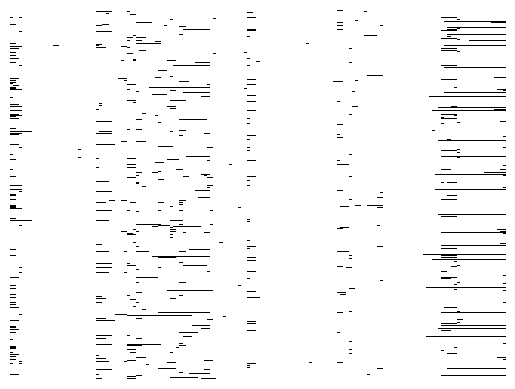

In [128]:
# Plot the heatmap
sns.heatmap(df.isna().astype(int), cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [129]:
# Join the dataframes based on the 'ID' column
if len(df.columns) == len(col_idx):
    if (df.columns == col_idx).all():
        df = pd.merge(
            pd.merge(
                pd.read_csv('data.tsv', delimiter='\t'),
                pd.DataFrame(
                    {
                        'Entry':[headers[idx].split('/')[0].split('_')[0] for idx in df.index],
                        'Index':list(df.index)
                    }
                ),
                on='Entry'
            ),
            df,
            left_on='Index',
            right_index=True,
            how='inner'
        ).copy()
print(df.info)

<bound method DataFrame.info of            Entry        Entry Name   
0     A0A401KD97  A0A401KD97_ASPAW  \
1     A0A024HID4  A0A024HID4_PSEKB   
2     A0A0B7G8U8  A0A0B7G8U8_KLEVA   
3     A0A0D1ZK14  A0A0D1ZK14_9EURO   
4     A0A0F3KB91  A0A0F3KB91_9NEIS   
...          ...               ...   
7193      X8BD72      X8BD72_MYCAV   
7194      X8C3G7      X8C3G7_MYCXE   
7195      X8C428      X8C428_MYCXE   
7196      X8C7K7      X8C7K7_MYCXE   
7197      Y0KGF3      Y0KGF3_9PROT   

                                          Protein names   
0     Bifunctional lycopene cyclase/phytoene synthas...  \
1     Carnitine monooxygenase oxygenase subunit (EC ...   
2     Carnitine monooxygenase oxygenase subunit (EC ...   
3     Choline monooxygenase, chloroplastic (EC 1.14....   
4     Carnitine monooxygenase oxygenase subunit (EC ...   
...                                                 ...   
7193                              Rieske domain protein   
7194                              Riesk

In [130]:
df['Protein names'].value_counts(normalize=True)

Protein names
Aromatic ring-hydroxylating dioxygenase subunit alpha                                                                                0.123784
(2Fe-2S)-binding protein                                                                                                             0.090025
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                                                  0.068213
Rieske (2Fe-2S) protein                                                                                                              0.062240
Rieske domain-containing protein                                                                                                     0.059600
                                                                                                                                       ...   
Dioxygenase (EC 1.14.12.12)                                                                                                          0

In [131]:
# Extract the substrate and enzyme names using regular expressions
matches = df['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())

df['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df = df.copy()

df[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
                                                          0.468047
                                        dioxygenase       0.185607
choline                                 monooxygenase     0.090164
phenylpropionate                        dioxygenase       0.073076
benzoate                                dioxygenase       0.042651
anthranilate                            dioxygenase       0.027508
salicylate                              hydroxylase       0.017505
                                        oxygenase         0.015421
biphenyl                                dioxygenase       0.010420
benzene                                 dioxygenase       0.008197
naphthalene                             dioxygenase       0.007780
carnitine                               monooxygenase     0.007780
cumate                                  dioxygenase       0.006669
halobenzoate                            dioxygenase       0.006113
benzoat

In [132]:
df['Enzyme'].value_counts(normalize=True)

Enzyme
                  0.468047
dioxygenase       0.389553
monooxygenase     0.099333
hydroxylase       0.018061
oxygenase         0.015838
demethylase       0.002917
oxidoreductase    0.001389
reductase         0.001389
cyclase           0.000834
synthase          0.000695
diooxygenase      0.000417
decarboxylase     0.000417
dyoxygenase       0.000417
ligase            0.000139
dehydrogenase     0.000139
helicase          0.000139
protease          0.000139
dioxyenase        0.000139
Name: proportion, dtype: float64

In [133]:
df['Substrate'].value_counts(normalize=True)

Substrate
                                          0.673659
choline                                   0.090164
phenylpropionate                          0.073076
benzoate                                  0.042790
anthranilate                              0.027508
salicylate                                0.017783
biphenyl                                  0.010420
benzene                                   0.008197
naphthalene                               0.007780
carnitine                                 0.007780
cumate                                    0.006669
halobenzoate                              0.006113
benzoate/toluate                          0.005279
terephthalate                             0.003751
phenylpropionate/cinnamate                0.003195
glycine/betaine                           0.002917
phthalate                                 0.002640
toluate                                   0.001389
methanesulfonate                          0.001389
phenoxybenzoate      

In [134]:
df['Label'] = df['Substrate'].str.cat(df['Enzyme'], sep=' ').str.strip()
df = df.copy()
df['Label'].value_counts(normalize=True)

Label
                                                        0.468047
dioxygenase                                             0.185607
choline monooxygenase                                   0.090164
phenylpropionate dioxygenase                            0.073076
benzoate dioxygenase                                    0.042651
anthranilate dioxygenase                                0.027508
salicylate hydroxylase                                  0.017505
oxygenase                                               0.015421
biphenyl dioxygenase                                    0.010420
benzene dioxygenase                                     0.008197
carnitine monooxygenase                                 0.007780
naphthalene dioxygenase                                 0.007780
cumate dioxygenase                                      0.006669
halobenzoate dioxygenase                                0.006113
benzoate/toluate dioxygenase                            0.005279
terephthalate dioxy

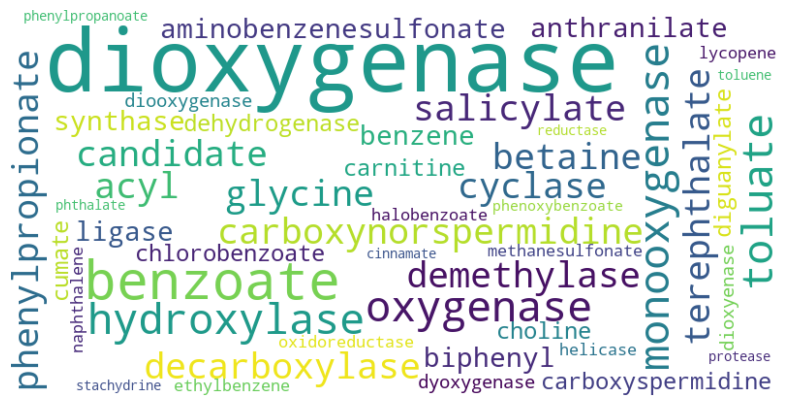

In [135]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(
        ' '.join(
            sorted(
                set([string for string in df.Label.values.tolist() if len(string) > 0])
            )
        )
    ),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

In [136]:
data = df[col_idx].drop_duplicates().fillna('-').copy()
data.info

<bound method DataFrame.info of      146  148  150  177  178  179  180  181  182  185   ... 1107 1108 1110   
0       E    M    D    V    E    A    N    W    K    L  ...    P    I    H  \
1       V    T    R    T    P    A    N    W    K    S  ...    I    A    H   
2       T    T    L    T    P    A    N    W    K    N  ...    I    A    H   
3       Q    M    Q    G    Q    Y    N    W    K    T  ...    P    L    Y   
4       V    T    A    T    P    A    N    W    K    I  ...    I    A    H   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7193    R    S    E    V    K    A    N    W    K    L  ...    L    R    H   
7194    V    L    D    F    P    I    N    W    K    L  ...    C    -    -   
7195    -    -    -    -    -    -    -    -    -    -  ...    L    R    H   
7196    -    -    -    -    H    A    N    W    K    M  ...    -    -    -   
7197    -    -    H    Y    Q    F    N    W    K    T  ...    L    E    H   

     1112 1113 1114 1116 1117 1

In [137]:
# Perform MCA
mca = MCA()
mca.fit(data)

# Access the results
coordinates = mca.transform(data)

# mca.plot(
#     data,
#     x_component=0,
#     y_component=1
# )

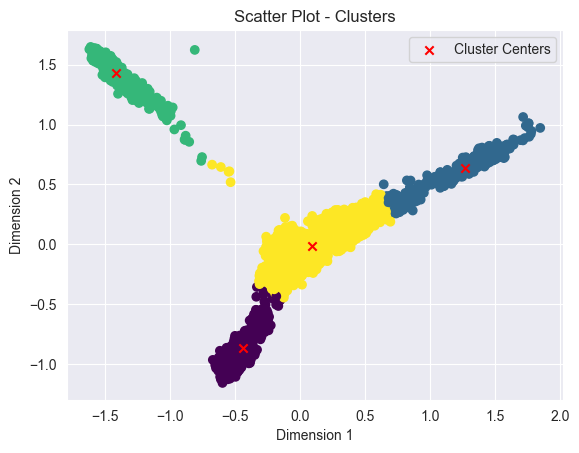

In [138]:
# Assuming 'coordinates' is the result of MCA

# Convert the coordinates to a NumPy array
coordinates = np.array(coordinates)

# Define a range of potential number of clusters to evaluate
min_clusters = 3
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    kmeans.fit(coordinates)
    labels = kmeans.labels_
    score = silhouette_score(coordinates, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_num_clusters, n_init=10)  # Set n_init explicitly
kmeans.fit(coordinates)
kmeans_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Plot the scatter plot colored by clusters
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot - Clusters')
plt.legend()
plt.show()

In [139]:
X = data
y = pd.get_dummies(kmeans_cluster_labels).astype(int) if len(
    set(kmeans_cluster_labels)
) > 2 else kmeans_cluster_labels

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get the column names for the encoded features
encoded_feature_names = []
for i, column in enumerate(X.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_name = f'{column}_{category}'
        encoded_feature_names.append(feature_name)

# Convert X_encoded to DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoded_feature_names)

# Create and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_encoded_df, y)

# Feature selection
feature_selector = SelectFromModel(rf, threshold='median')
X_selected = feature_selector.fit_transform(X_encoded_df, y)

selected_feature_indices = feature_selector.get_support(indices=True)
selected_features = X_encoded_df.columns[selected_feature_indices]

selected_features

Index(['146_-', '146_D', '146_E', '146_I', '146_K', '146_R', '146_S', '146_T',
       '146_V', '146_Y',
       ...
       '1119_K', '1119_L', '1119_N', '1119_Q', '1119_R', '1119_S', '1120_-',
       '1120_D', '1120_G', '1120_S'],
      dtype='object', length=1580)

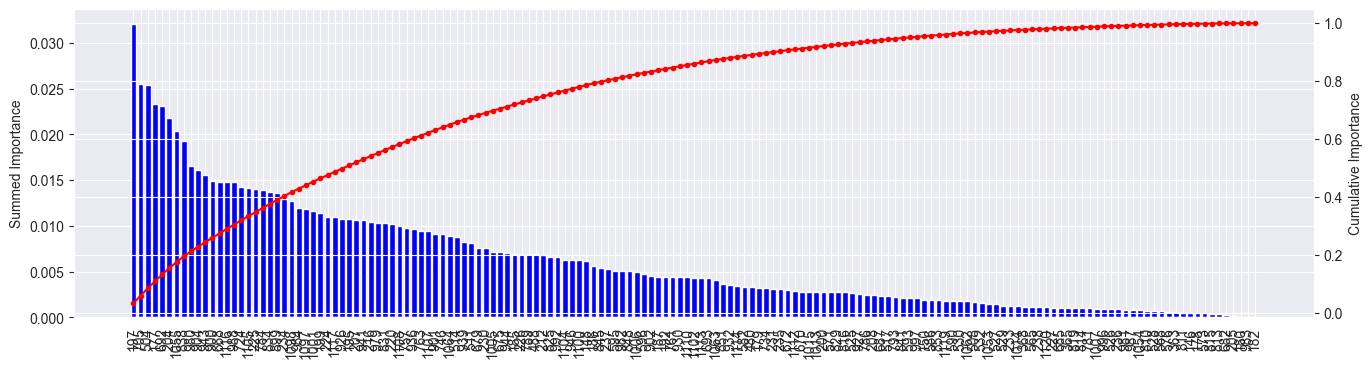

In [140]:
# Calculate feature importances for original columns
sorted_importance = pd.DataFrame(
    {
        'Residues': selected_features,
        'Importance': rf.feature_importances_[selected_feature_indices],
        'Columns': map(lambda x: int(x.split('_')[0]), selected_features)
    }
)[['Columns', 'Importance']].groupby('Columns').sum()['Importance'].sort_values(ascending=False)
sorted_features = sorted_importance.index

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importance, color='b')
ax1.set_ylabel('Summed Importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importance) / np.sum(sorted_importance), color='r', marker='.')
ax2.set_ylabel('Cumulative Importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, sorted_features)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

plt.show()


In [141]:
# Calculate cumulative sum of importance
cumulative_importance = np.cumsum(sorted_importance) / np.sum(sorted_importance)

# Find the index where cumulative importance exceeds or equals 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Get the values from sorted_features up to the index
selected_columns = sorted_features[:index+1].values

# Print the retrieved values
print(selected_columns)

[ 197  705  504  177  692  204 1055  838  980  904  943  900  668 1116
  988  724 1105  225  784  834  899  234 1098  984 1097 1001  199  224
 1117  926  195  207  941  216  979  831  220 1108  757  936  763 1107
  901  746 1064  514  939  511  679  230 1005  675  944  185  226  789
  488  212  825  992 1104  946 1100  148  186  845  237  595  982  848
 1006  596  902  187  192  761  930 1110 1102 1113  693 1063  851  932
 1114  582  480  179  734  231]


In [142]:
weights = henikoff(data[selected_columns])
print(weights)

0       0.002830
1       0.003243
2       0.003079
3       0.003164
4       0.002950
          ...   
7193    0.003741
7194    0.003263
7195    0.004629
7196    0.004478
7197    0.003993
Length: 7061, dtype: float64


In [143]:
data[selected_columns]

,197,705,504,177,692,204,1055,838,980,904,...,693,1063,851,932,1114,582,480,179,734,231
0,Y,T,Y,V,S,C,F,V,L,E,...,V,G,R,I,D,Q,K,A,D,N
1,Y,N,S,T,M,C,Y,I,R,I,...,F,G,N,Q,N,A,A,A,G,V
2,Y,N,L,T,M,C,Y,I,R,L,...,F,G,N,Q,N,T,K,A,P,V
3,Y,T,K,G,C,C,Y,V,L,D,...,M,G,V,I,N,E,T,Y,P,-
4,Y,N,G,T,M,C,Y,I,R,L,...,F,G,N,Q,H,D,L,A,A,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7193,F,L,K,V,V,F,V,L,G,V,...,I,F,A,L,K,P,E,A,Q,A
7194,F,S,P,F,V,N,H,Q,R,V,...,L,H,P,A,-,F,-,I,I,I
7195,-,L,K,-,M,-,V,L,A,L,...,L,F,P,L,K,P,M,-,P,-
7196,N,A,E,-,F,G,-,A,I,N,...,L,-,P,L,-,L,K,A,-,I


In [144]:
selected_residues = [x for x in selected_features if int(x.split('_')[0]) in selected_columns]
df_res = mca.column_coordinates(data[selected_columns]).loc[selected_residues]
df_res.info

<bound method DataFrame.info of                0         1
148_-   0.182498  0.170690
148_D  -1.026875  1.062573
148_F   0.388507  0.092148
148_H  -1.427837  1.532603
148_I  -0.481499 -1.078856
...          ...       ...
1117_-  1.513123  0.781356
1117_L -0.198032 -0.016027
1117_V -0.188689 -0.338406
1117_W  0.646198  0.256159
1117_Y -0.867584 -0.220582

[932 rows x 2 columns]>

In [145]:
# Create an empty graph
G = nx.Graph()
for idx in df_res.index:
    col, aa = idx.split('_')
    col = int(col)
    rows = data[selected_columns].index[data[selected_columns][col] == aa].tolist()
    # Filter and sum values based on valid indices
    p = weights.iloc[[i for i in rows if i < len(weights)]].sum()
    # Add a node with attributes
    G.add_node(
        f'{seq3(aa)}{col}',
        idx=idx,
        aa=aa,
        col=col,
        coord=(
            df_res.loc[idx,0],
            df_res.loc[idx,1]
        ),
        rows=rows,
        p=p
    )
G.nodes

NodeView(('Xaa148', 'Asp148', 'Phe148', 'His148', 'Ile148', 'Leu148', 'Met148', 'Thr148', 'Val148', 'Tyr148', 'Xaa177', 'Ala177', 'Cys177', 'Asp177', 'Glu177', 'Phe177', 'Gly177', 'His177', 'Ile177', 'Leu177', 'Val177', 'Tyr177', 'Ala179', 'Cys179', 'Phe179', 'Gly179', 'Lys179', 'Thr179', 'Tyr179', 'Xaa185', 'Cys185', 'Ile185', 'Leu185', 'Met185', 'Thr185', 'Val185', 'Trp185', 'Ala186', 'Phe186', 'Gly186', 'Ile186', 'Leu186', 'Gln186', 'Thr186', 'Val186', 'Tyr186', 'Ala187', 'Gly187', 'Ile187', 'Leu187', 'Met187', 'Asn187', 'Gln187', 'Val187', 'Trp187', 'Xaa192', 'Asp192', 'Glu192', 'Ile192', 'Xaa195', 'Ile195', 'Asn195', 'Thr195', 'Val195', 'Xaa197', 'Ala197', 'Cys197', 'Asp197', 'Glu197', 'Phe197', 'Gly197', 'Leu197', 'Asn197', 'Tyr197', 'Ala199', 'Cys199', 'His199', 'Ile199', 'Lys199', 'Leu199', 'Met199', 'Asn199', 'Gln199', 'Arg199', 'Ser199', 'Thr199', 'Val199', 'Ala204', 'Cys204', 'Asp204', 'Gly204', 'Met204', 'Pro204', 'Ser204', 'Thr204', 'Ala207', 'Cys207', 'Phe207', 'Ile207', 

In [146]:
nodelist = sorted(G.nodes(), key=lambda x: G.nodes[x]['p'], reverse=True)
df_res = df_res.loc[[G.nodes[u]['idx'] for u in nodelist]]
df_res.columns = ['x_mca', 'y_mca']
df_res = df_res.copy()
df_res

,x_mca,y_mca
1102_E,-0.188057,-0.094364
1005_Q,0.180337,-0.176911
192_E,-0.018907,0.026713
195_N,0.189398,-0.223559
1063_G,-0.463839,-0.179504
...,...,...
1110_P,-0.468332,0.057361
693_R,-0.341038,-0.723362
185_W,0.989902,0.424588
192_I,-0.583827,-1.125040


In [147]:
# Generate pairwise combinations
pairwise_comparisons = list(combinations(G.nodes, 2))

# Add edges to graph based on pairwise calculation of Jaccard's dissimilarity (1 - similarity)
for u, v in pairwise_comparisons:
    asymmetric_distance = set(G.nodes[u]['rows']) ^ set(G.nodes[v]['rows'])
    union = set(G.nodes[u]['rows']) | set(G.nodes[v]['rows'])
    weight = float(
        weights.iloc[[i for i in list(asymmetric_distance) if i < len(weights)]].sum()
    ) / float(
        weights.iloc[[i for i in list(union) if i < len(weights)]].sum()
    ) if G.nodes[u]['col'] != G.nodes[v]['col'] else 1.
    G.add_edge(
        u,
        v,
        weight = weight
    )

# Generate distance matrix
D = nx.to_numpy_array(G, nodelist=nodelist)

# Plot the distance matrix
fig, ax = plt.subplots()
im = ax.imshow(D, cmap='viridis')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

KeyboardInterrupt: 

In [ ]:
# Assuming D is the distance matrix

# Perform MDS to obtain the actual points
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
points = mds.fit_transform(D)

# Apply OPTICS on the points
optics = OPTICS()
optics.fit(points)

ordering = optics.ordering_
# Retrieve cluster labels and ordering information
cluster_labels = optics.labels_

# Plot the ordering analysis
plt.figure(figsize=(12, 4))
plt.bar(range(len(ordering)), ordering, width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

In [ ]:
df_res['x_mds'] = points[:,0]
df_res['y_mds'] = points[:,1]
df_res['label'] = cluster_labels
df_res = df_res.copy()
df_res

In [ ]:
# Find the unique values and their counts
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the proportion of unique values
proportions = counts / len(cluster_labels)

# Print the unique values and their proportions
for value, count, proportion in zip(unique_values, counts, proportions):
    print(value, count, proportion)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Plot for MCA
axs[0].set_xlabel('MCA Dimension 1', fontsize=14)
axs[0].set_ylabel('MCA Dimension 2', fontsize=14)
axs[0].set_title('Residues from MCA Colored by Cluster', fontsize=16)

# Plot for MDS
axs[1].set_xlabel('MDS Dimension 1', fontsize=14)
axs[1].set_ylabel('MDS Dimension 2', fontsize=14)
axs[1].set_title('Residues from MDS Colored by Cluster', fontsize=16)

x_mca = df_res['x_mca']
y_mca = df_res['y_mca']

x_mds = df_res['x_mds']
y_mds = df_res['y_mds']

labels = df_res['label']
unique_labels = np.unique(labels)
color_map = cm.get_cmap('tab10', len(unique_labels))

handles = []
all_labels = []

for i, cluster_label in enumerate(unique_labels):
    if cluster_label == -1:
        noise_color = 'grey'
        noise_marker = 'x'
        label = 'Noise'
    else:
        noise_color = color_map(i)
        noise_marker = 'o'
        label = f'Cluster {cluster_label}'

    scatter_mca = axs[0].scatter(x_mca[labels == cluster_label], y_mca[labels == cluster_label], color=noise_color, marker=noise_marker, label=label)
    scatter_mds = axs[1].scatter(x_mds[labels == cluster_label], y_mds[labels == cluster_label], color=noise_color, marker=noise_marker, label=label)

    # Collect the scatter plot handles and labels
    handles.append(scatter_mca)
    all_labels.append(label)

# Rearrange labels to fill one row first and then the second row
n_cols = 6  # Number of columns in the legend
all_labels_reordered = [all_labels[i::n_cols] for i in range(n_cols)]
all_labels_reordered = sum(all_labels_reordered, [])  # Flatten the nested list

# Create a single legend for both subplots with reordered labels
fig.legend(handles, all_labels_reordered, bbox_to_anchor=(0.5, 0.0), loc='upper center', borderaxespad=0, ncol=n_cols, fontsize=12)

# ...

# Adjust the layout to accommodate the legend
fig.tight_layout(rect=[0, 0.05, 1, 0.9])

# Show the plot
plt.show()

In [ ]:
unique_labels = np.unique(cluster_labels)
clusters = [[] for _ in unique_labels]

for i, cluster_label in enumerate(unique_labels):
    clusters[i] = np.where(cluster_labels == cluster_label)[0].tolist()

adhesion = []
for row_idx in data.index:
    temp = []
    for cluster in clusters:
        count = 0
        for cluster_idx in cluster:
            node_idx = nodelist[cluster_idx]
            if data.loc[row_idx, G.nodes[node_idx]['col']] == G.nodes[node_idx]['aa']:
                count += 1
        temp.append(float(count)/float(len(cluster)))
    adhesion.append(np.array(temp))
adhesion = np.array(adhesion)

In [ ]:
df_adh = pd.DataFrame(adhesion)
df_adh.columns = [f"Cluster {label+1}" if label >= 0 else "Noise" for label in unique_labels]
itemgetter_func = itemgetter(*data.index)
seq_ids = itemgetter_func(headers)
df_adh.index = seq_ids
df_adh.head()

In [ ]:
cbar_kws = {"orientation": "horizontal"}
g = sns.clustermap(df_adh, col_cluster=False, yticklabels=False, cbar_pos=(.4, .85, .4, .02), cbar_kws=cbar_kws)

In [152]:
# Run clustermap with potential performance improvement
Z = fastcluster.linkage(df_adh, method='ward')

# List to store silhouette scores
silhouette_scores = []

# Define a range of possible values for k
k_values = range(2, 10)

# Calculate silhouette score for each value of k
for k in k_values:
    labels = fcluster(Z, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(df_adh, labels))

# Find the index of the maximum silhouette score
best_index = np.argmax(silhouette_scores)

# Get the best value of k
best_k = k_values[best_index]

# Print the best value of k and its corresponding silhouette score
print("Best k:", best_k)
print("Best silhouette score:", silhouette_scores[best_index])

# Get the cluster labels
labels = fcluster(Z, best_k, criterion='maxclust')

# Print the cluster labels
print(np.unique(labels))

Best k: 8
Best silhouette score: 0.37246540542124507
[1 2 3 4 5 6 7 8]


In [ ]:
# tree = to_tree(Z, False)
# print(get_newick(tree, tree.dist, seq_ids))

# dn = hierarchy.dendrogram(Z)
# hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y', orientation='top')
# dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc', orientation='right')
# hierarchy.set_link_color_palette(None)  # reset to default after use
# plt.show()